Create a new PhilDB database
--

The next snippet imports some PhilDB exceptions and classes before showing how to create a PhilDB database using the create method. Alternate to the below code the commandline phil-create method could be used (e.g `phil-create bom_db`).

In [1]:
from phildb.create import create
from phildb.exceptions import AlreadyExistsError, DuplicateError
from phildb.database import PhilDB

try:
    create('bom_db')
except AlreadyExistsError:
    pass # Database already exists, so no creation required.

In [2]:
db = PhilDB('bom_db')

The below method parses the JSON data from the Bureau of Meterology into a Pandas Series:

In [3]:
import pandas as pd
import datetime

def parse(station_json, measurand):
    dates = []
    data = []
    for ob in station_json['observations']['data']:
        the_date = datetime.datetime.strptime(ob['aifstime_utc'], '%Y%m%d%H%M%S')
        if the_date.minute == 0 or the_date.minute == 30:
            dates.append(the_date)
            data.append(ob[measurand])
    dates.reverse()
    data.reverse()

    station_id = station_json['observations']['header'][0]['ID']
                                                                                 
    return station_id, pd.Series(data, dates)                                                                                


## Configure database
Define the measurand we are storing along with source and frequency

In [4]:
measurand = 'air_temp'
source = 'BOM_OBS'
freq = '30min'

try:
    db.add_measurand(measurand, measurand, 'Air Temperature')
except DuplicateError:
    pass # DuplicateError means the measurand already existed so no work needs to be done.

try:
    db.add_source('BOM_OBS', 'Australian Bureau of Meteorology Observations')
except DuplicateError:
    pass # DuplicateError means the source already existed so no work needs to be done.   

## Fetch data
Using Python requests we can get the JSON data to parse for the time series data and station ID:

In [5]:
import requests

json_data = requests.get('http://www.bom.gov.au/fwo/IDN60901/IDN60901.94767.json').json()
station_id, data = parse(json_data, measurand)

## Create/load data
Add the timeseries and timeseries_instance if required before loading the data:

In [6]:
try:
    db.add_timeseries(station_id)
except DuplicateError:
    pass # DuplicateError means the ID already existed so no work needs to be done.

try:
    db.add_timeseries_instance(station_id, freq, 'None', measurand = measurand, source = source)
except DuplicateError:
    pass # DuplicateError means the timeseries instance already existed so no work needs to be done.

db.write(station_id, freq, data, measurand = measurand, source = source)

## Read and plot
Here we read and plot the data we just loaded:

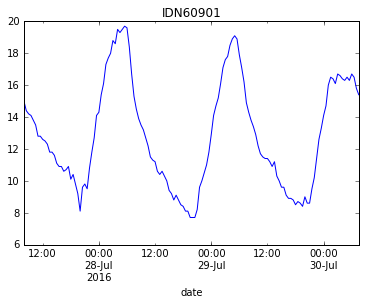

In [7]:
%matplotlib inline
ax = db.read(station_id, '30min').plot()
ax.set_title(station_id)